In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import altair as alt

from path_explain.path_explainer_tf import PathExplainerTF
from plot.scatter import scatter_plot
from plot.summary import summary_plot

In [3]:
n = 5000
d = 5
noise = 0.5
X = np.random.randn(n, d)
y = np.sum(X, axis=-1) + 2 * np.prod(X[:, 0:2], axis=-1) + np.random.randn(n)

In [4]:
threshold = int(n * 0.8)
X_train = X[:threshold]
y_train = y[:threshold]
X_test  = X[threshold:]
y_test  = y[threshold:]

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(d,)))
model.add(tf.keras.layers.Dense(units=10,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=5,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,
                                use_bias=False,
                                activation=None))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [7]:
learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.MeanSquaredError())

In [8]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=2, validation_split=0.8)

Train on 799 samples, validate on 3201 samples
Epoch 1/20
799/799 - 1s - loss: 8.3466 - val_loss: 6.6109
Epoch 2/20
799/799 - 0s - loss: 4.7338 - val_loss: 3.9225
Epoch 3/20
799/799 - 0s - loss: 4.3009 - val_loss: 3.0737
Epoch 4/20
799/799 - 0s - loss: 4.0211 - val_loss: 6.5444
Epoch 5/20
799/799 - 0s - loss: 3.5892 - val_loss: 1.5443
Epoch 6/20
799/799 - 0s - loss: 1.5451 - val_loss: 1.8918
Epoch 7/20
799/799 - 0s - loss: 2.3175 - val_loss: 1.5744
Epoch 8/20
799/799 - 0s - loss: 1.8361 - val_loss: 1.7134
Epoch 9/20
799/799 - 0s - loss: 1.5942 - val_loss: 1.4831
Epoch 10/20
799/799 - 0s - loss: 1.5529 - val_loss: 1.5306
Epoch 11/20
799/799 - 0s - loss: 1.3480 - val_loss: 1.2612
Epoch 12/20
799/799 - 0s - loss: 1.9574 - val_loss: 1.2287
Epoch 13/20
799/799 - 0s - loss: 1.2865 - val_loss: 1.3122
Epoch 14/20
799/799 - 0s - loss: 1.1847 - val_loss: 1.4701
Epoch 15/20
799/799 - 0s - loss: 1.4029 - val_loss: 2.9865
Epoch 16/20
799/799 - 0s - loss: 1.2160 - val_loss: 1.2930
Epoch 17/20
799/79

In [9]:
model.evaluate(X_test, y_test, batch_size=50, verbose=2)

1000/1 - 0s - loss: 1.1013


1.1762402653694153

In [10]:
y_test_pred = model.predict(X_test, batch_size=50)

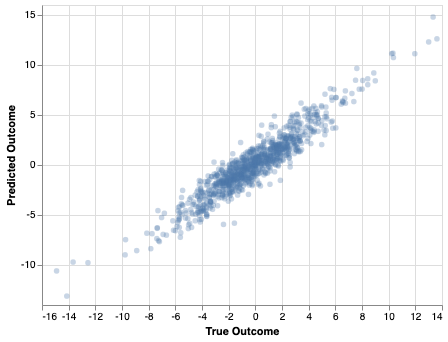

In [11]:
df = pd.DataFrame({
    'Predicted Outcome': y_test_pred[:, 0],
    'True Outcome': y_test
})
alt.Chart(df).mark_point(filled=True, opacity=0.3).encode(
    alt.X('True Outcome:Q'),
    alt.Y('Predicted Outcome:Q')
)

In [12]:
explainer = PathExplainerTF(model)

In [38]:
feature_values = X_test

In [39]:
attributions = explainer.attributions(feature_values, X_train,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(feature_values),
                     verbose=True)

100%|██████████| 1000/1000 [00:04<00:00, 204.21it/s]


In [40]:
interactions = explainer.interactions(feature_values, X_train,
                         batch_size=100, num_samples=100,
                         use_expectation=True, output_indices=[0] * len(feature_values),
                         verbose=True, interaction_index=None)

100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]


In [45]:
np.save('attributions.npy', attributions)
np.save('interactions.npy', interactions)

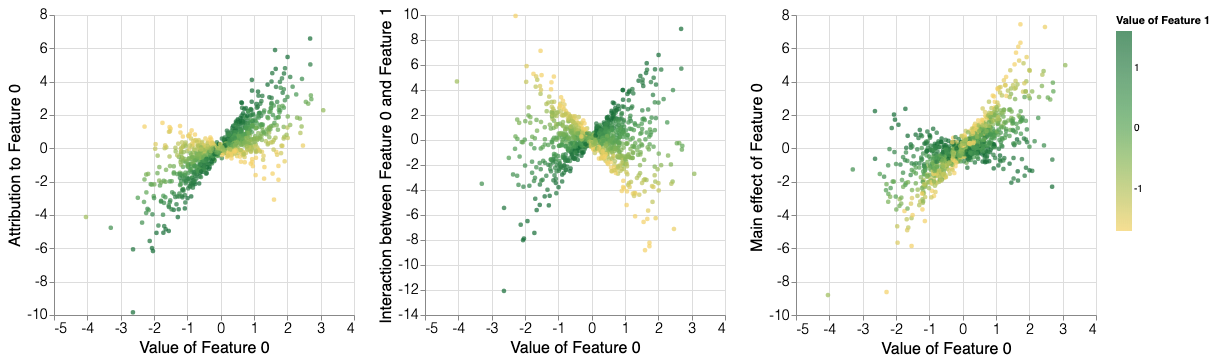

In [41]:
scatter_plot(attributions,
             feature_values,
             feature_index=0,
             interactions=interactions,
             color_by=1,
             feature_names=None)

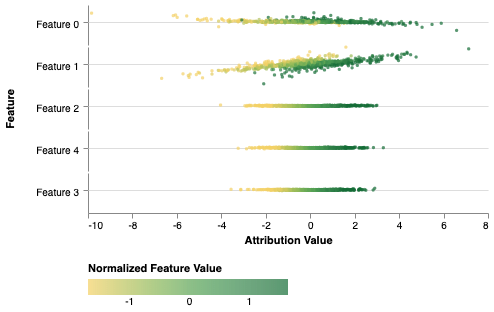

In [42]:
summary_plot(attributions,
             feature_values,
             interactions=interactions,
             interaction_feature=0,
             feature_names=None,
             plot_top_k=None)

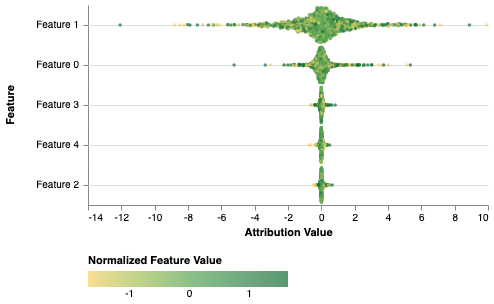

In [44]:
summary_plot(interactions[:, 0],
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)